In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

#Environment that evaluates operations immediately without creating graphs
tf.enable_eager_execution()


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/home/monster/.keras/datasets/flower_photos


In [4]:
for item in data_root.iterdir():
  print(item)

/home/monster/.keras/datasets/flower_photos/LICENSE.txt
/home/monster/.keras/datasets/flower_photos/sunflowers
/home/monster/.keras/datasets/flower_photos/tulips
/home/monster/.keras/datasets/flower_photos/roses
/home/monster/.keras/datasets/flower_photos/dandelion
/home/monster/.keras/datasets/flower_photos/daisy


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [7]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

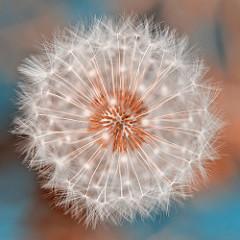

Image (CC BY 2.0)  by Nicolas Raymond



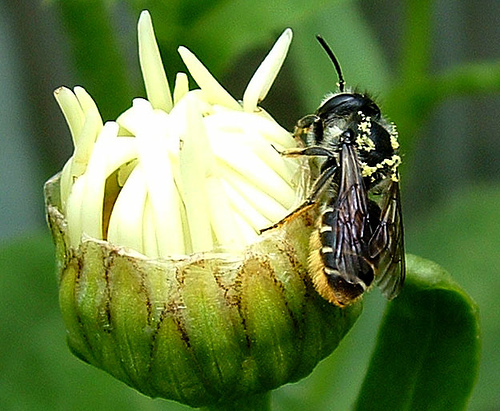

Image (CC BY 2.0)  by Rosana Prada



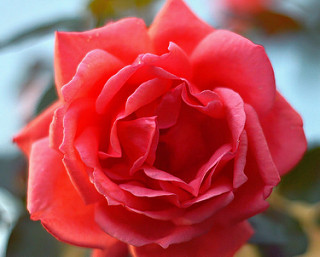

Image (CC BY 2.0)  by Micolo J



In [8]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [9]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 0, 4, 2, 1, 3, 1, 4, 1, 2]


In [12]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [13]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

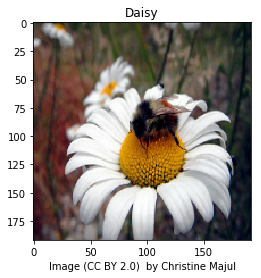

In [15]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())
plt.show()

In [17]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [27]:
BATCH_SIZE = 32

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [20]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

In [28]:
mobile_net.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
#Model expects its input to be normalized to the [-1,1] range:
#So before the passing it to the MobilNet model, we need to convert the input from a range of [0,1] to [-1,1].
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [22]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
#The MobileNet returns a 6x6 spatial grid of features for each image.
#Pass it a batch of images to see:

image_batch, label_batch = next(iter(keras_ds))

In [23]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [24]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [29]:
#model returns expected output
logit_batch = model(image_batch).numpy()

print("Shape:", logit_batch.shape)

Shape: (32, 5)


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [31]:
len(model.trainable_variables)

2

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [36]:
history =model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch)

Epoch 1/10
115/115==============================] - 14s 119ms/step - loss: 1.6090 - acc: 0.3207
Epoch 2/10
115/115==============================] - 6s 53ms/step - loss: 1.6094 - acc: 0.3204
Epoch 3/10
115/115==============================] - 7s 58ms/step - loss: 1.6094 - acc: 0.3255
Epoch 4/10
115/115==============================] - 6s 56ms/step - loss: 1.6086 - acc: 0.3293
Epoch 5/10
115/115==============================] - 6s 50ms/step - loss: 1.6094 - acc: 0.3310
Epoch 6/10
115/115==============================] - 6s 50ms/step - loss: 1.6090 - acc: 0.3171
Epoch 7/10
115/115==============================] - 6s 55ms/step - loss: 1.6094 - acc: 0.3245
Epoch 8/10
115/115==============================] - 6s 54ms/step - loss: 1.6094 - acc: 0.3141
Epoch 9/10
115/115==============================] - 6s 52ms/step - loss: 1.6090 - acc: 0.3231
Epoch 10/10
115/115==============================] - 6s 53ms/step - loss: 1.6090 - acc: 0.3228


In [37]:
history.history.keys()

dict_keys(['loss', 'acc'])

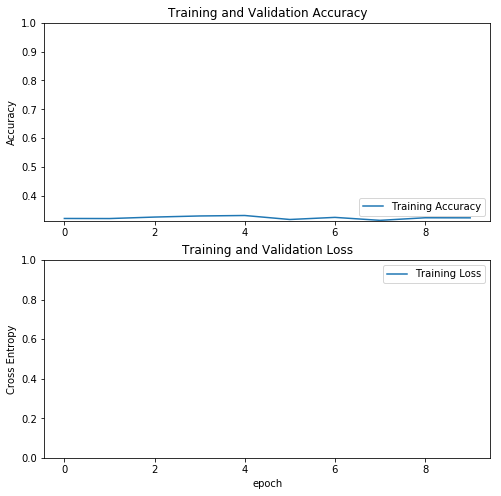

In [38]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()